In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import seaborn as sns

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
# !pip install livelossplot

In [ ]:
# !pip install tfds-nightly

In [ ]:
ds,info = tfds.load('so2sat/all', with_info=True)

# train_ds = tfds.load("so2sat/all", split="train[:60%]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/so2sat/all/2.1.0.incompleteJ77POB/so2sat-train.tfrecord


  0%|          | 0/352366 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/so2sat/all/2.1.0.incompleteJ77POB/so2sat-validation.tfrecord


  0%|          | 0/24119 [00:00<?, ? examples/s]

Dataset so2sat downloaded and prepared to /root/tensorflow_datasets/so2sat/all/2.1.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='so2sat',
    version=2.1.0,
    description='So2Sat LCZ42 is a dataset consisting of co-registered synthetic aperture radar
and multispectral optical image patches acquired by the Sentinel-1 and
Sentinel-2 remote sensing satellites, and the corresponding local climate zones
(LCZ) label. The dataset is distributed over 42 cities across different
continents and cultural regions of the world.

The full dataset (`all`) consists of 8 Sentinel-1 and 10 Sentinel-2 channels.
Alternatively, one can select the `rgb` subset, which contains only the optical
frequency bands of Sentinel-2, rescaled and encoded as JPEG.

Dataset URL: http://doi.org/10.14459/2018MP1454690
License: http://creativecommons.org/licenses/by/4.0',
    homepage='http://doi.org/10.14459/2018MP1454690',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=17),
        'sample_id': tf.int64,
        'sentinel1': Tensor(shape=(32, 32, 8), dtype=tf.float32)

In [ ]:
train_ds1 = tfds.load("so2sat/all", split="train[:80%]")

In [ ]:
valid_ds = tfds.load("so2sat/all", split="train[90%:]")

In [ ]:
# train_mv = train_ds.take(5000)
# for example in train_mv:
#   print(list(example.keys()))

1. take only Sentinel 2
2. Pre-processing and 1 hot encoding : is the data on tensorflow one hot encoded?
3. Batch our data into smaller sizes?
4. Build the model
5. Fit on training dataset
6. Test on validation

In [ ]:
# train_ds1.element_spec

In [ ]:
# valid_ds.element_spec

In [ ]:
# arr = []
# test_mv = train_ds.take(5)

# for ele in test_mv:
#   arr = np.array(ele['sentinel2'])

In [ ]:
# for training ds
S2 = []
label = []
for ele in train_ds1.as_numpy_iterator():
  S2.append(ele['sentinel2'])
  label.append(ele['label'])

In [ ]:
S2 = np.array(S2)

In [ ]:
label = np.array(label)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((S2, label))

In [ ]:
train_dataset = train_dataset.map(lambda x, y: {'sentinel2': x, 'label': y})

In [ ]:
# for valid ds
S2_valid = []
label_valid = []
for ele in valid_ds.as_numpy_iterator():
  S2_valid.append(ele['sentinel2'])
  label_valid.append(ele['label'])
S2_valid = np.array(S2_valid)
label_valid = np.array(label_valid)
valid_dataset = tf.data.Dataset.from_tensor_slices((S2_valid, label_valid))
valid_dataset = valid_dataset.map(lambda x, y: {'sentinel2': x, 'label': y})

In [ ]:
# df = tfds.as_dataframe(train_dataset.take(5), info)
# df

In [ ]:
# Pre-processing and 1 hot encoding

num_classes = 17

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.map(lambda d: (d["sentinel2"], tf.one_hot(d["label"], num_classes)))
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [ ]:
batch_size = 64

# preprocess training & validation sets
train_ds = prepare_for_training(train_dataset, batch_size=batch_size)
valid_ds = prepare_for_training(valid_dataset, batch_size=batch_size)


In [ ]:
# for el in train_ds.take(1):
#   print(el[0])


In [ ]:
# batch = next(iter(train_ds))

In [ ]:
# import pandas as pd

In [ ]:
# # import h5py
# # h5f = h5py.File('train_batch.h5', 'w')
# # h5f.create_dataset('train_batch', data=batch)

# np.save('train_batch', batch[0])


In [ ]:
# def show_batch(batch):
#   plt.figure(figsize=(16, 16))
#   for n in range(min(32, batch_size)):
#       ax = plt.subplot(batch_size//8, 8, n + 1)
#       # show the image
#       plt.imshow(batch[0][n,:,:,4])
#       # and put the corresponding label as title upper to the image
#       # plt.title(batch[1][n,:,:,4].numpy())
#       plt.axis('off')
#       plt.savefig("sample-images.png")

# # showing a batch of images along with labels
# show_batch(batch)

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 12.4 MB/s 


In [ ]:
import tensorflow_hub as hub
import tensorflow_addons as tfa

In [ ]:
# Build the model

# model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"

# # download & load the layer as a feature vector
# keras_layer = hub.KerasLayer(model_url, output_shape=[1280], trainable=True)

In [ ]:
# !pip install livelossplot

In [ ]:
# from tensorflow.keras.models import Sequential 
# from tensorflow.keras.backend import set_image_data_format 
# from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization 
# from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense 
# from tensorflow.keras import optimizers, losses, utils 
# # from livelossplot import keras_plot 
# # set_image_data_format('channels_first') 
# model = Sequential() 
# model.add(Conv2D(32, (5, 5), padding='same',input_shape=(32, 32,10))) 
# model.add(Activation('relu')) 
# model.add(Conv2D(32, (5, 5), padding='same')) 
# model.add(Activation('relu')) 
# model.add(MaxPool2D(2,2)) 
# model.add(Conv2D(64, (5, 5),padding='same')) 
# model.add(Activation('relu')) 
# model.add(Conv2D(64, (5, 5), padding='same')) 
# model.add(Activation('relu')) 
# model.add(MaxPool2D(2,2)) 
# model.add(Conv2D(128, (5, 5), padding='same')) 
# model.add(Activation('relu')) 
# model.add(Conv2D(128, (5, 5), padding='same')) 
# model.add(Activation('relu')) 
# model.add(MaxPool2D(2,2)) 
# model.add(Flatten()) 
# model.add(Dense(2048)) 
# model.add(Activation('relu')) 
# model.add(Dropout(0.25))
# model.add(Dense(17)) 
# model.add(Activation('softmax')) 
# adam = optimizers.Adam(lr=0.001) 
# model.compile(optimizer=adam, loss=losses.categorical_crossentropy, metrics=['categorical_accuracy'])

In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ReLU, \
    BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
model = Sequential([Conv2D(64, 3, padding="same", input_shape=(32, 32, 10),
                            kernel_regularizer=l2(.0001)),
                    ReLU(),

                    Conv2D(64, 3, padding="same", kernel_regularizer=l2(.0001)),
                    ReLU(),
                    MaxPooling2D(),

                    Conv2D(128, 3, padding="same", kernel_regularizer=l2(.0001)),
                    ReLU(),

                    Conv2D(128, 3, padding="same", kernel_regularizer=l2(.0001)),
                    ReLU(),
                    MaxPooling2D(),

                    Conv2D(256, 3, padding="same", kernel_regularizer=l2(.0001)),
                    ReLU(),

                    Conv2D(256, 3, padding="same", kernel_regularizer=l2(.0001)),
                    ReLU(),
                    MaxPooling2D(),

                    Conv2D(512, 3, padding="same", kernel_regularizer=l2(.0001)),
                    ReLU(),

                    Conv2D(512, 3, padding="same", kernel_regularizer=l2(.0001)),
                    ReLU(),
                    MaxPooling2D(),

                    Flatten(),
                    Dense(1024, kernel_regularizer=l2(.0001)),
                    ReLU(),
                    Dropout(.25),

                    Dense(512, kernel_regularizer=l2(.0001)),
                    ReLU(),
                    Dropout(.25),

                    Dense(256, kernel_regularizer=l2(.0001)),
                    ReLU(),
                    Dropout(.25),

                    Dense(64, kernel_regularizer=l2(.0001)),
                    ReLU(),
                    Dropout(.25),

                    Dense(17, activation="softmax")
                    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        5824      
                                                                 
 re_lu (ReLU)                (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                        

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=categorical_crossentropy, metrics=["accuracy"])

In [ ]:
info

tfds.core.DatasetInfo(
    name='so2sat',
    version=2.1.0,
    description='So2Sat LCZ42 is a dataset consisting of co-registered synthetic aperture radar
and multispectral optical image patches acquired by the Sentinel-1 and
Sentinel-2 remote sensing satellites, and the corresponding local climate zones
(LCZ) label. The dataset is distributed over 42 cities across different
continents and cultural regions of the world.

The full dataset (`all`) consists of 8 Sentinel-1 and 10 Sentinel-2 channels.
Alternatively, one can select the `rgb` subset, which contains only the optical
frequency bands of Sentinel-2, rescaled and encoded as JPEG.

Dataset URL: http://doi.org/10.14459/2018MP1454690
License: http://creativecommons.org/licenses/by/4.0',
    homepage='http://doi.org/10.14459/2018MP1454690',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=17),
        'sample_id': tf.int64,
        'sentinel1': Tensor(shape=(32, 32, 8), dtype=tf.float32)

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
os.path

<module 'posixpath' from '/usr/lib/python3.7/posixpath.py'>

In [ ]:
model_name = "so2_sat_satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)

In [ ]:
num_examples_t = 352366
num_examples_v = 352366

# training the model
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples_t * 0.8) // batch_size
# number of validation steps
n_validation_steps = int(num_examples_v*0.1) // batch_size

In [ ]:
# train the model
history = model.fit(
    train_ds, validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, epochs=10, 
    callbacks=[model_checkpoint]
)

Epoch 1/10
4404/4404 [==============================] - ETA: 0s - loss: 1.4427 - accuracy: 0.5913
Epoch 1: val_loss improved from inf to 1.11737, saving model to results/so2_sat_satellite-classification.h5
4404/4404 [==============================] - 6059s 1s/step - loss: 1.4427 - accuracy: 0.5913 - val_loss: 1.1174 - val_accuracy: 0.6639
Epoch 2/10
4404/4404 [==============================] - ETA: 0s - loss: 0.9408 - accuracy: 0.7339
Epoch 2: val_loss improved from 1.11737 to 0.75221, saving model to results/so2_sat_satellite-classification.h5
4404/4404 [==============================] - 6240s 1s/step - loss: 0.9408 - accuracy: 0.7339 - val_loss: 0.7522 - val_accuracy: 0.7857
Epoch 3/10
4404/4404 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.7931
Epoch 3: val_loss improved from 0.75221 to 0.66196, saving model to results/so2_sat_satellite-classification.h5
4404/4404 [==============================] - 6148s 1s/step - loss: 0.7465 - accuracy: 0.7931 - val_loss:

In [ ]:
# train_score = model.evaluate(train_ds, verbose=0)
# print('train loss, train acc:', train_score)

# validation_score = model.evaluate(valid_ds, verbose=0)
# print('validation loss, validation acc:', validation_score)

model.save("so2_sat_satellite-classification.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/model/so2_sat_satellite-classification.h5")

In [ ]:
test_ds = tfds.load("so2sat/all", split="validation")

In [ ]:
# for test ds
S2_test = []
label_test = []
for ele in test_ds.as_numpy_iterator():
  S2_test.append(ele['sentinel2'])
  label_test.append(ele['label'])
S2_test = np.array(S2_test)
label_test = np.array(label_test)
test_dataset = tf.data.Dataset.from_tensor_slices((S2_test, label_test))
test_dataset = test_dataset.map(lambda x, y: {'sentinel2': x, 'label': y})

In [ ]:
np.save('/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/so2_valid_X', S2_test)
np.save('/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/so2_valid_Y', label_test)

In [ ]:
test_ds = prepare_for_training(test_dataset, batch_size=batch_size)


In [ ]:
valid_ds.element_spec

(TensorSpec(shape=(None, 32, 32, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 17), dtype=tf.float32, name=None))

In [ ]:
# # prediction_probability = model.predict_proba(test_dataset, verbose=0)
# prediction_class = model.predict_classes(test_dataset, verbose=0)

classes_x=model.predict(S2_valid) 

In [ ]:
np.argmax(classes_x,axis=-1)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [ ]:
# classes_x[0]

# class_names = list(set(label_test))
# class_names
prediction_class = np.argmax(classes_x,axis=-1)
# prediction_class = model.predict_classes(S2_test, verbose=0)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

accuracy = accuracy_score(label_valid, prediction_class)
print('Accuracy Score: %f' % accuracy)


Accuracy Score: 0.895224


In [ ]:
confusion_matrix = confusion_matrix(label_valid, prediction_class)
print("Confusion Matrix:")
print(confusion_matrix)

ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot


In [ ]:
# import scikitplot as skplt
# plot_CM = skplt.metrics.plot_confusion_matrix(label_test, prediction_class)
# plot_CM.figure.savefig("Confusion_Matrix.jpg")

In [ ]:
import sklearn

In [ ]:
import matplotlib.pyplot as plt


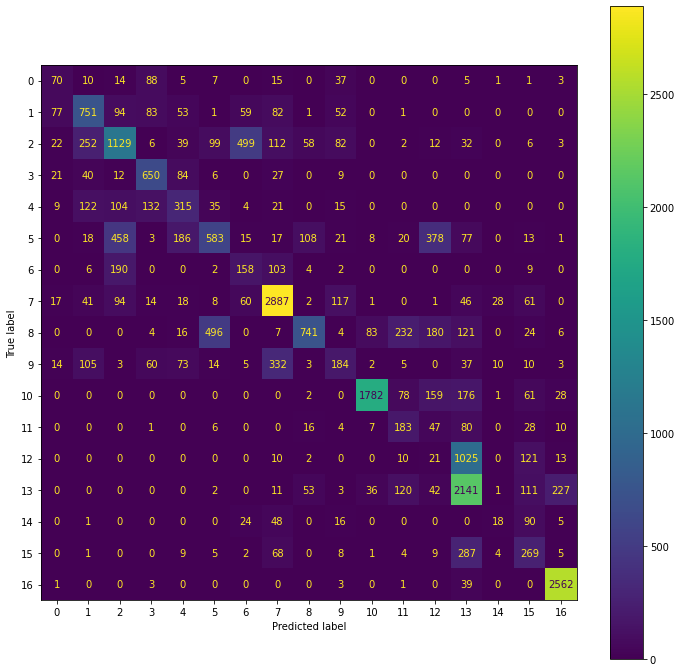

In [ ]:
cm = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
plt.rcParams["figure.figsize"] = (12,12)
cm.plot()
plt.show()

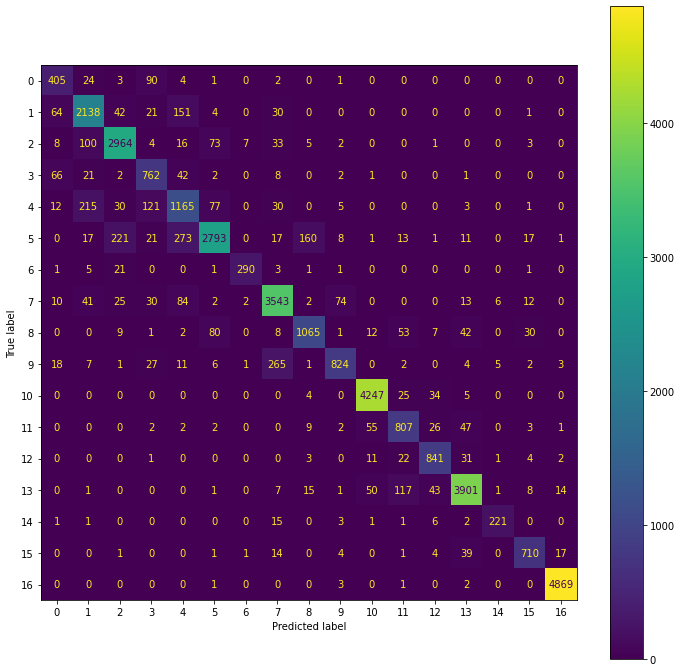

AttributeError: ignored

In [ ]:
cm = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
plt.rcParams["figure.figsize"] = (12,12)
cm.plot()
plt.show()



In [ ]:
roc_auc = roc_auc_score(label_valid, classes_x, average="macro", multi_class="ovo")
print('Area Under the Receiver Operating Characteristic Curve (ROC AUC): %f' % roc_auc)



Area Under the Receiver Operating Characteristic Curve (ROC AUC): 0.994044


In [ ]:
!pip install yellowbrick

In [ ]:
model = load_model("/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/model/so2_sat_satellite-classification.h5")

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
set(label_valid)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [ ]:
label_valid_bin = label_binarize(label_valid, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
prediction_class_bin = label_binarize(prediction_class, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

# classes_x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


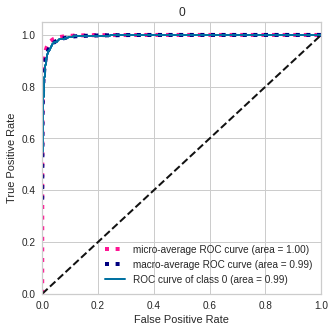

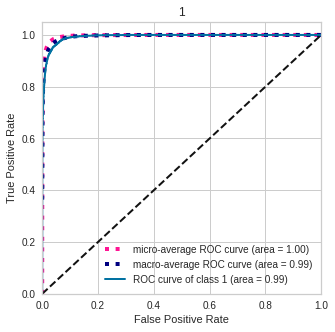

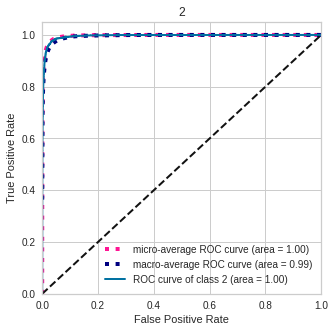

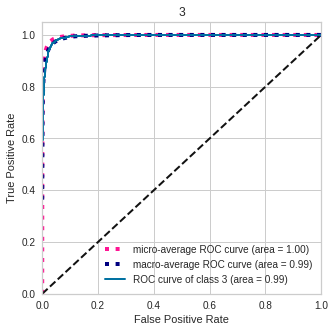

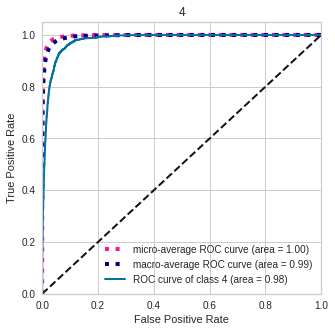

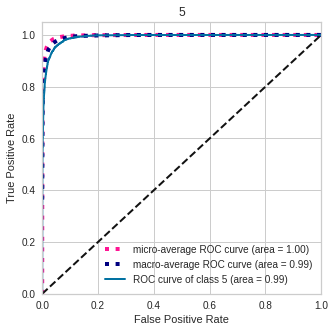

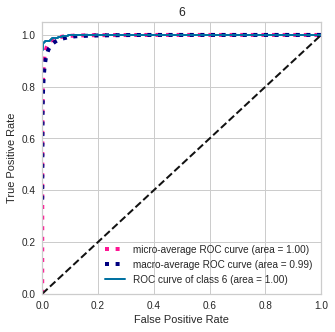

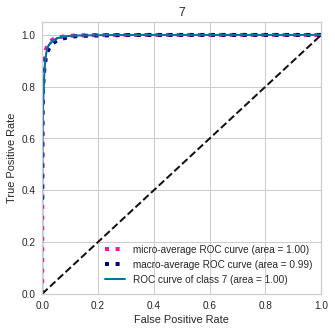

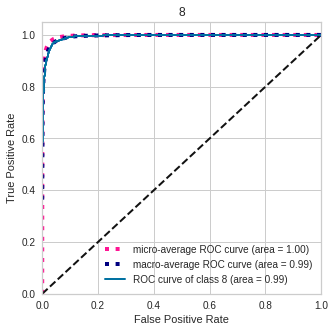

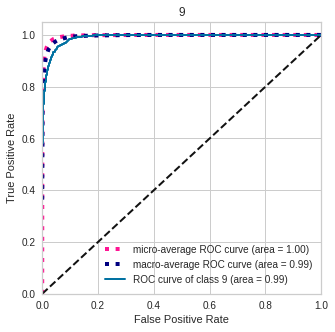

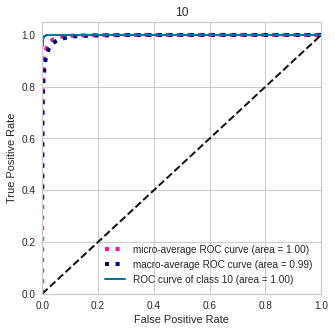

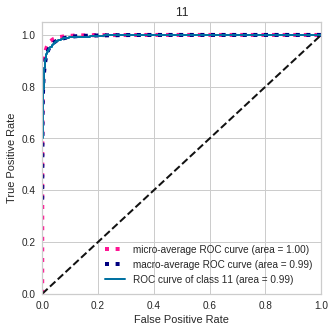

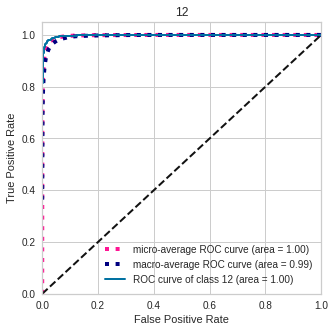

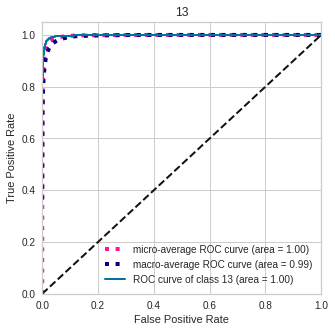

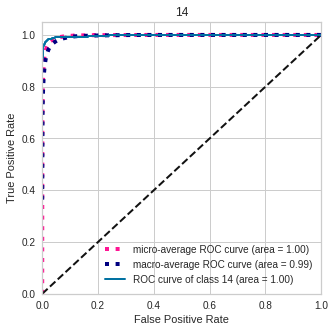

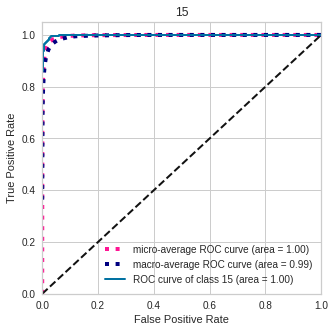

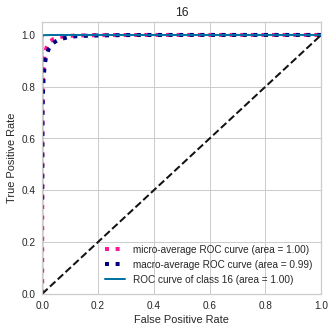

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Plot linewidth.
lw = 2
n_classes = 17

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_valid_bin[:, i], classes_x[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_valid_bin.ravel(), classes_x.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


# Plot all ROC curves

for i in range(0,17):
  # ax = plt.subplot(2, 2, i+1)
  plt.figure(figsize = (5, 5))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  
  plt.plot(fpr[i], tpr[i], lw=lw,
          label='ROC curve of class {0} (area = {1:0.2f})'
          ''.format(i, roc_auc[i]))
    
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(i)
  plt.legend(loc="lower right")
  plt.show()